# 🟦 MLP- MNIST

# import & 난수seed

In [1]:
import torch
from torch import nn
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime


generator = torch.Generator().manual_seed(42)   # 독립적인 난수 시퀀스 생성.
# 많은 PyTorch 함수에 generator= 매개변수가 있다.


# 인공신경망의 하이퍼 파라미터들.

In [2]:
# '하이퍼 파라미터'
#   모델이 학습하는 파라미터 가 아니다
#   학습전에 사람이 지정해 주어야 하는 파라미터다.

# 인공신경망에서의 하이퍼 파라미터들은 많~다
#   (지금까지 배운 범위 에선 다음과 같은 하이퍼 파라미터 들이 있다)
#   - 추가할 은닉층의 개수
#   - 각 층의 뉴런 개수
#   - 활성화 함수
#   - 층의 종류
#   - 배치(batch) 사이즈 : batch_size= 매개변수
#   - epochs

#  그 밖에도
#   - 경사하강법(Optimizer) 알고리즘
#   - 규제.  ex) Dropout
#   - 각 층의 하이퍼 파라미터들..

# 데이터 셋 준비

## 데이터셋 로딩 & 전처리

In [3]:
# MNIST 데이터셋: 28x28 크기의 흑백 손글씨 이미지 (0~9, 총 10개 클래스를 가진 분류문제).

**transforms.ToTensor()**

`transforms.ToTensor()` 은 PyTorch의 `torchvision.transforms`에서 제공하는 변환 함수로, **PIL 이미지나 NumPy 배열(H x W x C, 값 범위 0\~255)** 형태의 이미지를 **PyTorch Tensor 형태(C x H x W, 값 범위 0\~1)** 로 변환합니다.

---

1. **자료형 변환**

   * 입력: PIL.Image 또는 NumPy ndarray (dtype=uint8, 0\~255)
   * 출력: `torch.FloatTensor` (dtype=float32)

2. **차원 순서 변경**

   * 일반 이미지: `(높이, 너비, 채널)` → PyTorch 텐서: `(채널, 높이, 너비)`
   * 예: (H=224, W=224, C=3) → (C=3, H=224, W=224)

3. **값 범위 스케일링**

   * 0\~255 정수 값 → 0\~1 실수 값
   * 즉, `pixel_value / 255.0`

In [4]:
train_dataset = datasets.MNIST(
    root='MNIST_data/',
    train=True,   # 학습용 60000개 데이터
    transform=transforms.ToTensor(),  # 0~255 사이 픽셀값을 0.0~1.0 사이의 실수형 Tensor 로 변환
    download=True,
)

test_dataset = datasets.MNIST(
    root='MNIST_data/',
    train=False,  # 테스트용 10,000개 데이터
    transform=transforms.ToTensor(),  # 0~255까지의 값을 0~1 사이의 실수형 tensor로 변환시켜줌
    download=True,
    )

100%|██████████| 9.91M/9.91M [00:00<00:00, 60.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.90MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.16MB/s]


In [5]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [6]:
# torchvision 데이터셋의 타켓 클래스 이름들
classes = train_dataset.classes
classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

## 학습/검증 데이터 분리: random_split()

**random_split()**

https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.random_split

```python
torch.utils.data.random_split(
  dataset,  # Dataset
  lengths,  # split 할 lenths 들
  generator=<torch._C.Generator object>
)
```

In [7]:
# 학습 데이터(60,000개)를 train(85%) + validation(15%) 으로 분할.
# Train: 51,000개
# Validation: 9,000개

train_dataset_size = int(len(train_dataset) * 0.85)
validation_dataset_size = int(len(train_dataset) * 0.15)


train_dataset, validation_dataset = \
  random_split(train_dataset, [train_dataset_size, validation_dataset_size],
               generator=generator)

print(len(train_dataset), len(validation_dataset), len(test_dataset))


# 51000 9000 10000

51000 9000 10000


## DataLoader

In [8]:
# DataLoader: 데이터셋을 batch 단위로 나누어 학습에 공급.
# batch_size=32 → 한 번의 학습 step에 32개 이미지 사용.
# shuffle=True → 매 epoch마다 데이터 순서를 섞어서 모델이 순서에 의존하지 않도록 함.
# generator=   random seed

BATCH_SIZE = 32

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                                  shuffle=True, generator=generator)

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE,
                                       shuffle=True, generator=generator)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                 shuffle=True, generator=generator)



# 배치의 개수 확인
len(train_dataset_loader), len(validation_dataset_loader), len(test_dataset_loader)


# (1594, 282, 313)

(1594, 282, 313)

## 첫번째 배치의 데이터 확인

In [9]:
# 첫 배치
images, labels = next(iter(train_dataset_loader))

images.shape, labels.shape

# (torch.Size([32, 1, 28, 28]), torch.Size([32]))

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [10]:
# (torch.Size([32, 1, 28, 28]), torch.Size([32]))
#         [batch_size, channel, height, width]

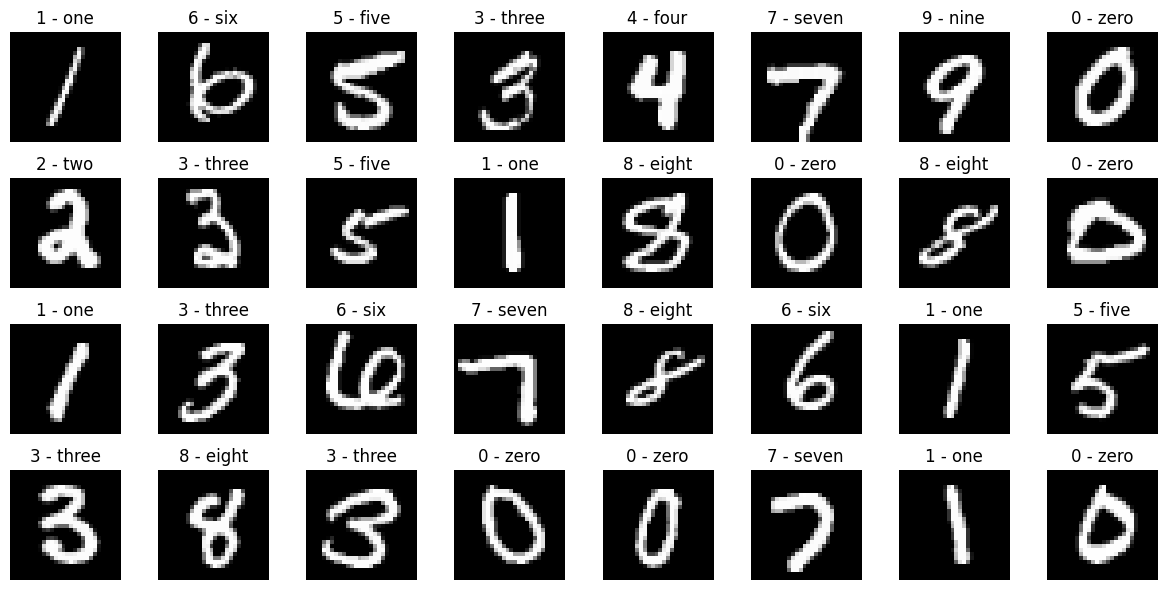

In [11]:
# 위 batch 를 4 x 8 로 시각화

fig, axes = plt.subplots(4, 8, figsize=(12, 6))
axes = axes.flatten()  # ravel() 로 해도 된다. (1차원 펼치기)

for i in range(BATCH_SIZE):
  img = images[i].squeeze().numpy()   # [1, 28, 28] -> [28, 28]
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(classes[labels[i].item()])
  axes[i].axis('off')

plt.tight_layout()
plt.show()

# Flatten layer

In [12]:
# Flatten layer
#   batch 차원을 제외하고 나머지 입력차원을 모두 일렬로 펼치는 역할
#   입력에 곱해지는 가중치나 절편은 없다.
#   즉 모델 파라미터 없고, 학습하는 층이 아니라 -> 모델의 성능에 영향을 주는 레이어는 아니다

# 모델 정의

In [13]:
# 입력: (batch_size, 1, 28, 28) 이미지.
# Flatten으로 → (batch_size, 784) 벡터화.
# 2개 fully connected layer (784→100, 100→10).
# 출력: (batch_size, 10) → 각 클래스별 점수(logit).

class MyDeepLearningModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(784, 100)
    self.activate1 = nn.Sigmoid()
    self.fc2 = nn.Linear(100, 10)

  def forward(self, data):
    data = self.flatten(data)
    data = self.fc1(data)
    data = self.activate1(data)
    logits = self.fc2(data)
    return logits

# 모델 생성
model = MyDeepLearningModel()

# 파라미터 확인
for name, child in model.named_children():
  print('🔶', name)
  total = 0
  for param_name, param in child.named_parameters():
    print('  🟡', param_name, '📍', param.data.shape, ':', param.numel())
    total += param.numel()
  print('   total params:', total)



🔶 flatten
   total params: 0
🔶 fc1
  🟡 weight 📍 torch.Size([100, 784]) : 78400
  🟡 bias 📍 torch.Size([100]) : 100
   total params: 78500
🔶 activate1
   total params: 0
🔶 fc2
  🟡 weight 📍 torch.Size([10, 100]) : 1000
  🟡 bias 📍 torch.Size([10]) : 10
   total params: 1010


# 손실함수 & optimizer

In [14]:
# 손실 함수: CrossEntropyLoss
#     softmax + negative log likelihood 결합.  <- softmax 함수가 포함되어 있다
#     다중 분류 문제에서 자주 사용.

loss_function = nn.CrossEntropyLoss()

# Optimizer: 확률적 경사하강법 SGD
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

# 학습(train) 함수

In [19]:
# forward → loss 계산 → backward → optimizer step 순서로 학습.
# 학습 중 평균 손실과 정확도 계산.

def model_train(dataloader, model, loss_function, optimizer):

  model.train()   # 학습모드. 모델 파라미터 업데이트. Dropout 활성화

  train_loss_sum = 0
  train_correct = 0  # 모델이 맞춘 샘플수 (누적)
  train_total = 0   # epoch 전체에서 처리한 샘플수 (누적)

  total_train_batch = len(dataloader)

  for images, labels in dataloader:

    # x_train = images.view(-1, 28 * 28)  # (batch_size, 1, 28, 28) -> (batch_size, 784)
    x_train = images  # 어짜피 모델에서 최초에 Flatten 함.
    y_train = labels

    outputs = model(x_train)  # outputs => (batch_size, 10)

    loss = loss_function(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss_sum += loss.item()

    train_total += y_train.size(0)  # label 열 사이즈
      # y_train 은 '현재 batch 의 label tensor 다. shape = [batch_size]  값은 0~9
      # y_train.size(0) 는 그 텐서의 첫 번째 차원(배치 차원)의 길이를 반환합니다 → 현재 배치의 샘플 개수.
      #   보통 batch_size(예: 32)이지만, 마지막 배치는 더 작을 수 있음(예: 8).

      # train_total는 에포크 전체에서 처리한 '샘플 수의 누적 합'입니다.
      #   “이번 배치의 샘플 수를 전체 샘플 수에 더한다”라는 뜻입니다.
      # 결과: 에포크가 끝나면 train_total은 그 에포크에서 모델이 본 전체 샘플 수(예: 51,000)가 됩니다.


    # 이번 배치에서 모델이 맞춘 샘플 수를 계산해서 누적
    train_correct += (torch.argmax(outputs, 1)==y_train).sum().item()  # 예측한 값과 일치한 값의 합.
      # outputs 의 shape 는 (batch_size, 10) (각 샘플마다 10개 클래스에 대한 logits)

      #  torch.argmax(outputs, 1)
      #   - 차원 1 (클래스 차원) 에서  최댓값의 인덱스를 구한다
      #   - 결과는 (batch_size,) 형태의 정수 텐서이고, 각 원소는 모델이 예측한 클래스(0~9)입니다.
      #   - 참고] 동점(같은 최대값이 여러 개)인 경우에는 가장 먼저 나타나는 인덱스를 반환합니다.

      # torch.argmax(outputs, 1)==y_train
      # 예측(정수 텐서)과 정답 레이블 y_train을 원소별로 비교합니다.
      # 결과는 torch.bool 타입의 텐서 (batch_size,)이며, 맞은 위치는 True, 틀린 위치는 False.

      # (...).sum()
      # Boolean 텐서의 sum()은 True의 개수를 더한 정수형 텐서를 반환합니다. (각 True가 1로 취급)
      # 결과는 이번 배치에서 맞춘 개수(텐서, 스칼라 텐서).

      # .item()
      # .item()은 0차원 텐서를 파이썬 숫자(예: int)로 변환합니다.
      # 그 값을 train_correct에 더해 누적합니다.


  # train 데이터 평균 오차 계산
  train_avg_loss = train_loss_sum / total_train_batch

  # train 데이터 평균 정확도 계산 (%)
  train_avg_accuracy = 100 * train_correct / train_total

  return (train_avg_loss, train_avg_accuracy)


In [16]:
"""
[예시 (숫자로 단계별 계산)]

작동을 직관적으로 보려면 간단한 수치 예시가 도움이 됩니다.

▶가정: 한 에포크에 배치가 5개, 각 배치의 샘플 수 모두 32(마지막도 동일).

  - total_train_batch = 5

  - train_total는 매 배치 더해서 32 + 32 + 32 + 32 + 32 = 160

각 배치에서 맞춘 개수(예시): 28, 27, 30, 29, 31 → train_correct = 28+27+30+29+31 = 145

▶정확도 계산:

  1. train_correct / train_total = 145 / 160

  2. 145 / 160 = 0.90625

  2. 100 * 0.90625 = 90.625 → train_avg_accuracy = 90.625 (%)

▶손실 예시: 각 배치의 loss.item() 값이 0.30, 0.28, 0.32, 0.31, 0.29이라면

  1. train_loss_sum = 0.30+0.28+0.32+0.31+0.29 = 1.50

  2. train_avg_loss = train_loss_sum / total_train_batch = 1.50 / 5 = 0.30
"""
None

# 검증(validation) 함수

In [20]:
# 모델 파라미터는 고정된 상태에서 validation 데이터 성능 확인.
# 오버피팅 여부 체크 가능.

def model_evaluate(dataloader, model, loss_function, optimizer):

    model.eval() # 평가 모드(추론 모드, 검증모드) (Dropout 비활성화)

    with torch.no_grad(): #미분하지 않겠다는 것, 즉 모델 파라미터를 업데이트 시키지 않겠다는 의미

        val_loss_sum = 0
        val_correct=0
        val_total = 0

        total_val_batch = len(dataloader)

        for images, labels in dataloader: # images에는 이미지, labels에는 0-9 숫자

            # reshape input image into [batch_size by 784]
            # label is not one-hot encoded
            # x_val = images.view(-1, 28 * 28) #처음 크기는 (batch_size, 1, 28, 28) / 이걸 (batch_size, 784)로 변환
            x_val = images
            y_val = labels

            outputs = model(x_val)
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()

            val_total += y_val.size(0)  # label 열 사이즈 같음
            val_correct += ((torch.argmax(outputs, 1)==y_val)).sum().item() # 예측한 값과 일치한 값의 합

        val_avg_loss = val_loss_sum / total_val_batch # 검증 데이터 평균 오차 계산
        val_avg_accuracy = 100*val_correct / val_total # 검증 데이터 평균 정확도 계산

    return (val_avg_loss, val_avg_accuracy)

# 테스트(test) 함수

In [21]:
# 학습이 끝난 뒤 최종 test set 성능 측정.
# ↓ model_evaluate() 와 동일한 코드
def model_test(dataloader, model):

    model.eval() # 평가 모드 (Dropout 비활성화)

    with torch.no_grad(): #test set으로 데이터를 다룰 때에는 gradient를 주면 안된다.

        test_loss_sum = 0
        test_correct=0
        test_total = 0

        total_test_batch = len(dataloader)

        for images, labels in dataloader: # images에는 이미지, labels에는 0-9 숫자

            # reshape input image into [batch_size by 784]
            # label is not one-hot encoded
            # x_test = images.view(-1, 28 * 28) #처음 크기는 (batch_size, 1, 28, 28) / 이걸 (batch_size, 784)로 변환
            x_test = images
            y_test = labels

            outputs = model(x_test)
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()

            test_total += y_test.size(0)  # label 열 사이즈 같음
            test_correct += ((torch.argmax(outputs, 1)==y_test)).sum().item() # 예측한 값과 일치한 값의 합

        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100*test_correct / test_total

        print('accuracy:', test_avg_accuracy)
        print('loss:', test_avg_loss)

# 학습

In [ ]:
# 20 epoch 동안 학습 진행.
# 각 epoch마다 학습/검증 손실 및 정확도 출력.
# 결과는 리스트에 저장 → 이후 시각화 가능.


train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):
  # model train
  train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)
  train_loss_list.append(train_avg_loss)
  train_accuracy_list.append(train_avg_accuracy)

  # model evaluate
  val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)  # evaluation
  val_loss_list.append(val_avg_loss)
  val_accuracy_list.append(val_avg_accuracy)

  # 매 epoch 마다 출력
  print('epoch:', '%02d' % (epoch + 1),
        'train loss =', '{:.4f}'.format(train_avg_loss), 'train accuracy =', '{:.4f}'.format(train_avg_accuracy),
        'validation loss =', '{:.4f}'.format(val_avg_loss), 'validation accuracy =', '{:.4f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time =>', end_time - start_time)



epoch: 01 train loss = 1.9996 train accuracy = 51.3902 validation loss = 1.5433 validation accuracy = 70.6333
epoch: 02 train loss = 1.1545 train accuracy = 76.2294 validation loss = 0.8817 validation accuracy = 81.3222
epoch: 03 train loss = 0.7462 train accuracy = 83.2804 validation loss = 0.6443 validation accuracy = 84.8778
epoch: 04 train loss = 0.5827 train accuracy = 86.1725 validation loss = 0.5325 validation accuracy = 86.8000
epoch: 05 train loss = 0.4978 train accuracy = 87.6275 validation loss = 0.4704 validation accuracy = 87.9778
epoch: 06 train loss = 0.4463 train accuracy = 88.4706 validation loss = 0.4303 validation accuracy = 88.7556
epoch: 07 train loss = 0.4118 train accuracy = 89.0882 validation loss = 0.4023 validation accuracy = 89.2333
epoch: 08 train loss = 0.3873 train accuracy = 89.5118 validation loss = 0.3832 validation accuracy = 89.5556
epoch: 09 train loss = 0.3689 train accuracy = 89.9118 validation loss = 0.3689 validation accuracy = 89.7667
epoch: 10 

In [ ]:
"""
epoch: 01 train loss = 1.9996 train accuracy = 51.3902 validation loss = 1.5433 validation accuracy = 70.6333
epoch: 02 train loss = 1.1545 train accuracy = 76.2294 validation loss = 0.8817 validation accuracy = 81.3222
...
epoch: 19 train loss = 0.2875 train accuracy = 91.7176 validation loss = 0.2962 validation accuracy = 91.5556
epoch: 20 train loss = 0.2829 train accuracy = 91.8412 validation loss = 0.2930 validation accuracy = 91.7333
elapsed time => 0:02:28.706646
"""
None

# 🟡활성화 함수

## 기울기 소실 (Vanishing gradient) 문제
- 활성화 함수 때문에

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FokTU1%2FbtrCH4Fx7Ro%2Fm5f9UkRkl7CP3dUEgXTtk1%2Fimg.png)

## ReLU 활성화 함수
- ReLU(Rectified Linear Unit, 렐루)

![](https://blog.kakaocdn.net/dn/vgJna/btqQzRGmwcO/TK3KTMlz4CYag8rBTKfYkK/img.png)


In [ ]:
# 0보다 크면 그대로 출력하고, 0보다 작으면, 0을 출력하는 '비선형' 함수
# 이미지 분류에 많이 사용되는 활성화 함수, DNN 에서 뛰어난 성능.

## 모델 (ReLU 사용) & optimizer 재정의

In [ ]:
class MyDeepLearningModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(784, 100)
    self.activate1 = nn.ReLU()   # ReLU 활성화 함수를 hidden layer 출력에 적용
    self.fc2 = nn.Linear(100, 10)

  def forward(self, data):
    data = self.flatten(data)
    data = self.fc1(data)
    data = self.activate1(data)
    logits = self.fc2(data)
    return logits

# 모델 생성
model = MyDeepLearningModel()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

## 학습

In [ ]:
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):
  # model train
  train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)
  train_loss_list.append(train_avg_loss)
  train_accuracy_list.append(train_avg_accuracy)

  # model evaluate
  val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)  # evaluation
  val_loss_list.append(val_avg_loss)
  val_accuracy_list.append(val_avg_accuracy)

  # 매 epoch 마다 출력
  print('epoch:', '%02d' % (epoch + 1),
        'train loss =', '{:.4f}'.format(train_avg_loss), 'train accuracy =', '{:.4f}'.format(train_avg_accuracy),
        'validation loss =', '{:.4f}'.format(val_avg_loss), 'validation accuracy =', '{:.4f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time =>', end_time - start_time)


epoch: 01 train loss = 0.9297 train accuracy = 79.1039 validation loss = 0.4626 validation accuracy = 87.9889
epoch: 02 train loss = 0.3997 train accuracy = 89.1412 validation loss = 0.3670 validation accuracy = 89.7444
epoch: 03 train loss = 0.3407 train accuracy = 90.4078 validation loss = 0.3294 validation accuracy = 90.5889
epoch: 04 train loss = 0.3110 train accuracy = 91.1647 validation loss = 0.3067 validation accuracy = 91.1778
epoch: 05 train loss = 0.2891 train accuracy = 91.8059 validation loss = 0.2890 validation accuracy = 91.7778
epoch: 06 train loss = 0.2709 train accuracy = 92.3725 validation loss = 0.2719 validation accuracy = 92.3222
epoch: 07 train loss = 0.2543 train accuracy = 92.8784 validation loss = 0.2596 validation accuracy = 92.5889
epoch: 08 train loss = 0.2399 train accuracy = 93.3000 validation loss = 0.2458 validation accuracy = 92.8889
epoch: 09 train loss = 0.2269 train accuracy = 93.6961 validation loss = 0.2332 validation accuracy = 93.4222
epoch: 10 

In [ ]:
"""
🟦 Sigmoid 사용한 결과
epoch: 01 train loss = 1.9996 train accuracy = 51.3902 validation loss = 1.5433 validation accuracy = 70.6333
epoch: 02 train loss = 1.1545 train accuracy = 76.2294 validation loss = 0.8817 validation accuracy = 81.3222
...
epoch: 19 train loss = 0.2875 train accuracy = 91.7176 validation loss = 0.2962 validation accuracy = 91.5556
epoch: 20 train loss = 0.2829 train accuracy = 91.8412 validation loss = 0.2930 validation accuracy = 91.7333
elapsed time => 0:02:28.706646

🟦 ReLU 사용한 결과
epoch: 01 train loss = 0.9297 train accuracy = 79.1039 validation loss = 0.4626 validation accuracy = 87.9889
epoch: 02 train loss = 0.3997 train accuracy = 89.1412 validation loss = 0.3670 validation accuracy = 89.7444
...
epoch: 19 train loss = 0.1440 train accuracy = 96.0490 validation loss = 0.1673 validation accuracy = 95.1889
epoch: 20 train loss = 0.1390 train accuracy = 96.1588 validation loss = 0.1623 validation accuracy = 95.3111
elapsed time => 0:02:24.991615

"""
None

# 성능평가 (test)

In [ ]:
model_test(test_dataset_loader, model)

accuracy: 95.6
loss: 0.14646506652878688


# 시각화 loss, accuracy curve

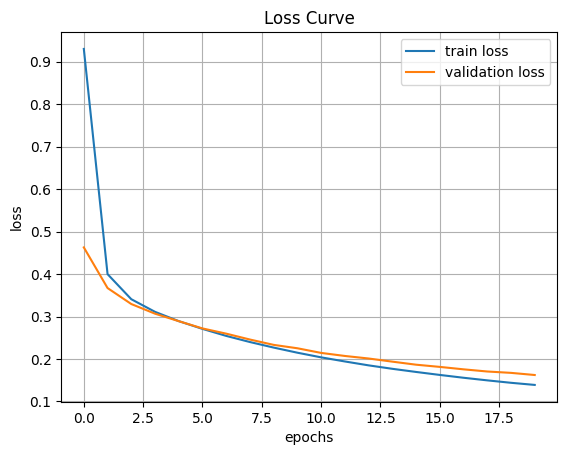

In [ ]:
plt.title('Loss Curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')

plt.legend()
plt.show()

## validation loss (검증손실)

In [ ]:
# 검증데이터에 대한 점수도 필요하다 -> 검증 손실!
#  왜?  overfit / underfit 여부 확인.

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2024/04/1-02-1-scaled.jpg)

In [ ]:
# 정확도와 loss 값은 항상 반비레 하는게 아니다 ★★

# 신경망 모델에 최적화 대상은 '정확도' 가 아니라 '손실함수' 다! ★★

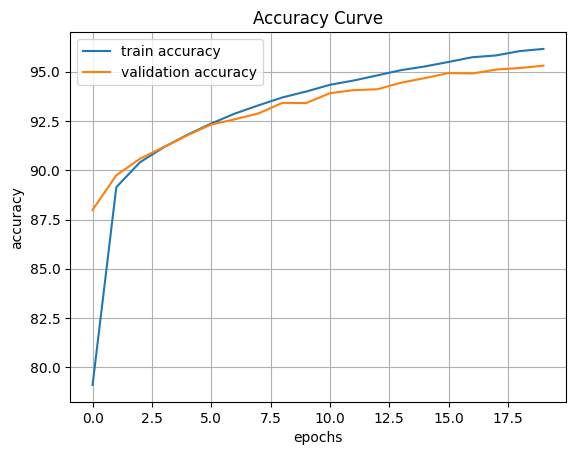

In [ ]:
plt.title('Accuracy Curve')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')

plt.legend()
plt.show()

In [ ]:
# ↑ 초기에 검증 손실이 감소하다가 다섯번째 에포크 만에 다시 '상승(둔화)'하기 시작한다.
#   훈련손실은 꾸준이 감소하고 있기 때문에 과대적합 모델이 만들어지기 시작하는 거다.
#   검증 손실이 상승하는 시점을 가능한 뒤로 늦출수만 있다면
#   검증 세트에 대한 손실이 줄어들 뿐 아니라 검증 세트에 대한 정확도도 증가시킬수 있을겁니다

In [ ]:
# overfit 을 막기위함 .  규제 (regularization)

# 신경망의 대표적인 규제 -> Dropout

# 🟡Dropout 드롭아웃

- 신경망에서 사용되는 대표적인 규제 (regularization)
- 제프리 힌터 (Geoffrey Hinton) 이 소개
- '훈련과정' 에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 (즉 뉴런의 출력을 0으로 만들어)
과대 적합을 억제

![](https://wikidocs.net/images/page/196790/01_dropout.png)

In [ ]:
#  '훈련과정' 에서 층에 있는 일부 뉴런을 랜덤하게 꺼서 (즉 뉴런의 출력을 0으로 만들어)
# 과대 적합을 억제

# 왜 과대적합을 막을까?
#  - 특정 뉴런에 과대하게 의존하는 것을 줄여, 신경망이 더 안정적인 예측을 만들수 있다.
#  - 마치 여러개의 신경망을 '앙상블' 하는 것처럼 동작한다.  이또한 과대적합을 막아주는 좋은 기법.


In [ ]:
# PyTorch 의 드롭아웃은 torch.nn.Dropout 클래스로 제공
# 어떤 층의 뒤에 Dropout 을 두어 이 층의 출력을 랜덤하게 0 으로 만들어 준다.
# Dropout 은 '층' 처럼 사용되지만 훈련되는 모델 파라미터는 없습니다.

# model.train() 모드에서만 Dropout 동작이 활성화 됨!

## 모델 재정의 (Dropout 사용)

In [22]:
class MyDeepLearningModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(784, 100)
    self.activate1 = nn.ReLU()   # ReLU 활성화 함수를 hidden layer 출력에 적용
    self.dropout = nn.Dropout(p=0.3) # 오버핏 규제 Dropout. train()모드에서 학습시 무작위로 뉴런의 30% 비활성화
    self.fc2 = nn.Linear(100, 10)

  def forward(self, data):
    data = self.flatten(data)
    data = self.fc1(data)
    data = self.activate1(data)
    data = self.dropout(data)  # 은닉층 결과에 Dropout 적용
    logits = self.fc2(data)
    return logits

# 모델 생성
model = MyDeepLearningModel()

optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

## 학습

In [ ]:
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):
  # model train
  train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)
  train_loss_list.append(train_avg_loss)
  train_accuracy_list.append(train_avg_accuracy)

  # model evaluate
  val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)  # evaluation
  val_loss_list.append(val_avg_loss)
  val_accuracy_list.append(val_avg_accuracy)

  # 매 epoch 마다 출력
  print('epoch:', '%02d' % (epoch + 1),
        'train loss =', '{:.4f}'.format(train_avg_loss), 'train accuracy =', '{:.4f}'.format(train_avg_accuracy),
        'validation loss =', '{:.4f}'.format(val_avg_loss), 'validation accuracy =', '{:.4f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time =>', end_time - start_time)


epoch: 01 train loss = 1.0326 train accuracy = 73.2275 validation loss = 0.4899 validation accuracy = 87.5111
epoch: 02 train loss = 0.4810 train accuracy = 86.2667 validation loss = 0.3781 validation accuracy = 89.6444
epoch: 03 train loss = 0.4058 train accuracy = 88.4275 validation loss = 0.3342 validation accuracy = 90.6778
epoch: 04 train loss = 0.3639 train accuracy = 89.7843 validation loss = 0.3063 validation accuracy = 91.3111
epoch: 05 train loss = 0.3325 train accuracy = 90.5176 validation loss = 0.2810 validation accuracy = 92.1667
epoch: 06 train loss = 0.3078 train accuracy = 91.2137 validation loss = 0.2631 validation accuracy = 92.7333
epoch: 07 train loss = 0.2874 train accuracy = 91.9078 validation loss = 0.2465 validation accuracy = 93.2778
epoch: 08 train loss = 0.2701 train accuracy = 92.3000 validation loss = 0.2311 validation accuracy = 93.4667
epoch: 09 train loss = 0.2544 train accuracy = 92.7863 validation loss = 0.2203 validation accuracy = 93.8000
epoch: 10 

In [ ]:
"""
🟦 Sigmoid 사용한 결과
epoch: 01 train loss = 1.9996 train accuracy = 51.3902 validation loss = 1.5433 validation accuracy = 70.6333
epoch: 02 train loss = 1.1545 train accuracy = 76.2294 validation loss = 0.8817 validation accuracy = 81.3222
...
epoch: 19 train loss = 0.2875 train accuracy = 91.7176 validation loss = 0.2962 validation accuracy = 91.5556
epoch: 20 train loss = 0.2829 train accuracy = 91.8412 validation loss = 0.2930 validation accuracy = 91.7333
elapsed time => 0:02:28.706646

🟦 ReLU 사용한 결과
epoch: 01 train loss = 0.9297 train accuracy = 79.1039 validation loss = 0.4626 validation accuracy = 87.9889
epoch: 02 train loss = 0.3997 train accuracy = 89.1412 validation loss = 0.3670 validation accuracy = 89.7444
...
epoch: 19 train loss = 0.1440 train accuracy = 96.0490 validation loss = 0.1673 validation accuracy = 95.1889
epoch: 20 train loss = 0.1390 train accuracy = 96.1588 validation loss = 0.1623 validation accuracy = 95.3111
elapsed time => 0:02:24.991615

🟦 Dropout 사용한 결과
epoch: 01 train loss = 1.0326 train accuracy = 73.2275 validation loss = 0.4899 validation accuracy = 87.5111
epoch: 02 train loss = 0.4810 train accuracy = 86.2667 validation loss = 0.3781 validation accuracy = 89.6444
...
epoch: 19 train loss = 0.1758 train accuracy = 94.9706 validation loss = 0.1562 validation accuracy = 95.3889
epoch: 20 train loss = 0.1696 train accuracy = 95.1529 validation loss = 0.1512 validation accuracy = 95.6000
elapsed time => 0:02:31.643574

"""
None

## 시각화 loss curve

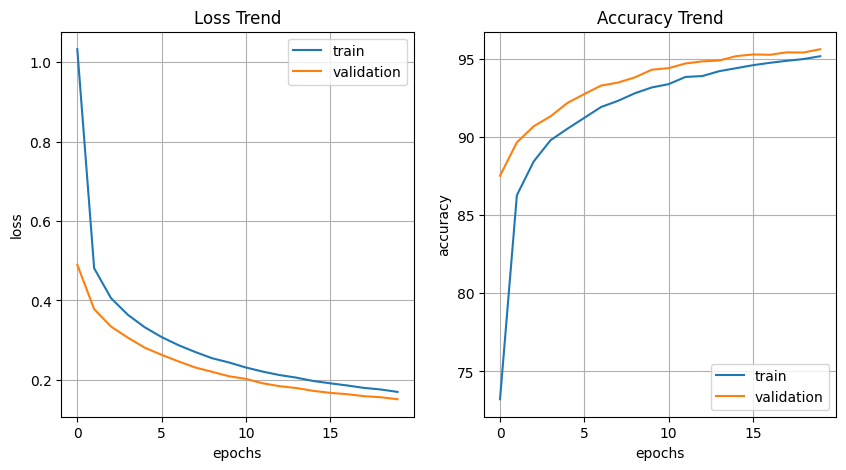

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()

# 🟦 MLP - FashionMNIST

# FashionMNIST 데이터셋

- MNIST 는
  - 손글씨 이미지 데이터셋
  - 0 ~ 9 까지의 숫자 손글씨

- **FashionMNIST** 는 숫자 대신 패션 아이템 이미지로 구성

![](https://www.researchgate.net/publication/373046669/figure/fig1/AS:11431281180809965@1691723436709/The-FashionMNIST-dataset-consists-of-10-classes-of-monochrome-clothing-items-and-is.png)

  - 많은 딥러닝 라이브러리에서 이 데이터를 가져올수 있도록 제공함

## 데이터셋 준비

In [23]:
train_dataset = datasets.FashionMNIST(
    root='FashionMNIST_data/',
    train=True,   # 학습용 60000개 데이터
    transform=transforms.ToTensor(),  # 0~255 사이 픽셀값을 0.0~1.0 사이의 실수형 Tensor 로 변환
    download=True,
)

test_dataset = datasets.FashionMNIST(
    root='FashionMNIST_data/',
    train=False,  # 테스트용 10,000개 데이터
    transform=transforms.ToTensor(),  # 0~255까지의 값을 0~1 사이의 실수형 tensor로 변환시켜줌
    download=True,
    )

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 306kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.60MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 16.6MB/s]


In [24]:
print(len(train_dataset))
classes = train_dataset.classes
print(classes)

60000
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


## 학습, 검증 데이터셋 분리

In [25]:
train_dataset_size = int(len(train_dataset) * 0.85)
validation_dataset_size = int(len(train_dataset) * 0.15)


train_dataset, validation_dataset = \
  random_split(train_dataset, [train_dataset_size, validation_dataset_size],
               generator=generator)

print(len(train_dataset), len(validation_dataset), len(test_dataset))

51000 9000 10000


## DataLoader

In [26]:
BATCH_SIZE = 32

train_dataset_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE,
                                  shuffle=True, generator=generator)

validation_dataset_loader = DataLoader(dataset=validation_dataset, batch_size=BATCH_SIZE,
                                       shuffle=True, generator=generator)

test_dataset_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE,
                                 shuffle=True, generator=generator)

## 첫번째 배치 확인

In [27]:
images, labels = next(iter(train_dataset_loader))

print(images.shape, labels.shape)

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [28]:
labels

tensor([6, 6, 1, 2, 7, 2, 4, 8, 2, 8, 1, 9, 1, 2, 3, 5, 1, 8, 0, 4, 6, 0, 5, 0,
        9, 0, 1, 4, 8, 1, 6, 2])

In [29]:
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

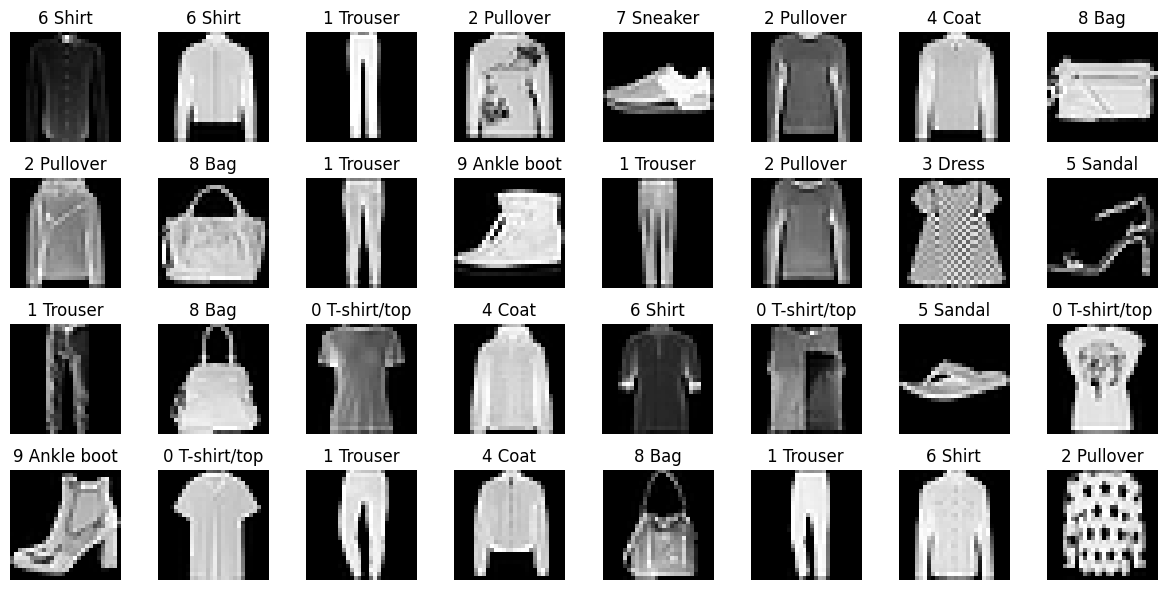

In [30]:
# BATCH_SIZE 가 32.  이를 4 x 8 로 시각화해보자
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(12, 6))
axes = axes.flatten()  # ravel() 해도 된다 (1차원 펼치기)

for i in range(BATCH_SIZE):
  img = images[i].squeeze().numpy()  # [1, 28, 28] -> [28, 28] 로 변환
  axes[i].imshow(img, cmap='gray')
  axes[i].set_title(f"{labels[i].item()} {classes[labels[i].item()]}") # lable 값과 클래스 이름까지 출력
  axes[i].axis('off')

plt.tight_layout()
plt.show()

In [31]:
# 모델 생성

# optimizer 생성

# 학습

# 평가 (test)

# 결과 (loss curve)

## 🟡 Optimizer 경사하강법 알고리즘
- 옵티마이저,
- PyTorch 가 제공하는 경사하강법 알고리즘(들)

In [31]:
# PyTorch의 DataLoader의 기본 batch_size=1 는 1이다
# 적절한 batch_size 를 지정하여 '미니배치 경사하강법' 을 구현한다

#  경사하강법 알고리즘들은 torch.optim 에서 제공되나.
#  https://docs.pytorch.org/docs/stable/optim.html

# PyTorch 는 다양한 종류의 경사하강법 알고리즘 제공하며
#   이를 옵티마이저 (optimizer) 라 한다
# 어떠한 옵티마이저 를 선택할른지도 하이퍼 파라미터다.

# 경사하강법 알고리즘의 학습률(learning rate) 파라미터 또한 조정가능한 하이퍼 파라미터다.

- Convex function (볼록 함수)

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FqQ8wX%2FbtrClmTlA7P%2FDPYMsPcWqAUrMiKnk0oAUk%2Fimg.png)

- Non-convec function (비볼록 함수)

![](https://blog.kakaocdn.net/dn/bi7dC6/btrCokN0IbK/EeSswSjpUAH9ArFqi98uB1/img.gif)

- local minimum

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FSxaKf%2FbtrCiQ2rVKR%2FcBfOFOoubyevkbzdQNqfV0%2Fimg.png)

- saddle point 문제

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FdwcRcc%2FbtrClmshN0q%2F4fJGFrTOMfGR2J8S0WF3Zk%2Fimg.png)

- momentum
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FkEqvr%2FbtrCkKUukCF%2FxLBzKe8UGeolScjr2pF0GK%2Fimg.png)

- learning rate
![](https://www.jeremyjordan.me/content/images/2018/02/Screen-Shot-2018-02-24-at-11.47.09-AM.png)

### SGD optimizer

**torch.optim.SGD**

https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html

```python
class torch.optim.SGD(
  params,  # 모델 파라미터들
  lr=0.001,  # 학습률
  momentum=0,
  dampening=0,
  weight_decay=0,
  nesterov=False,
  *,
  maximize=False,
  foreach=None,
  differentiable=False, fused=None)
```

In [31]:
# SGD optimizer 는 확률적 경사하강법 사용
#  그런데 이름에서 풍기는 (Stochastic ..) 것과는 달리
#  1개의 샘플을 뽑아서 훈련하지는 않고,  앞서 언급한 것처럼 이또한 미니배치(mini-batch) 를 사용합니다

### lr= (learning rate)

In [32]:
# SGD 클래스의 learning rate (학습률) 기본값은 0.001 이다
# 이를 변경하려면 lr= 매개변수를 지정해준다
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

### momentum=

In [31]:
# momentum= 기본값은 0
#    (사용할 경우 일반적으로 0.9 이상을 사용함 -> 그레디언트 가속도 적용 -> '모멤텀 최적화' 사용)


### nesterov=

In [31]:
# nesterov=True 로 주면
# '네스테로프 모멘텀 최적화 (nesterov momentum optimization, 또는 네스테로프 가속 경사)' 를 사용

# 모멘텀 최적화는 '2번 반복'
# 일반적으로 기본모멘텀 최적화보다는 나은 성능 기대

In [33]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, nesterov=True)

### adaptive learning rate (적응적 학습률)

AdaGrad, RMSprop
---
**torch.optim.Adagrad**

https://docs.pytorch.org/docs/stable/generated/torch.optim.Adagrad.html


```python
class torch.optim.Adagrad(
  params,
  lr=0.01,
  lr_decay=0,
  weight_decay=0,
  initial_accumulator_value=0,
  eps=1e-10,
  foreach=None,
  *,
  maximize=False,
  differentiable=False,
  fused=None)
```

---
**torch.optim.RMSprop**

https://docs.pytorch.org/docs/stable/generated/torch.optim.RMSprop.html


```python
class torch.optim.RMSprop(
  params,
  lr=0.01,
  alpha=0.99,
  eps=1e-08,
  weight_decay=0,
  momentum=0,
  centered=False,
  capturable=False,
  foreach=None,
  maximize=False,
  differentiable=False)
```



In [34]:
# '적응적 학습률 (adaptive learning rate)'
# 모델의 최적점 가까이 갈수록 학습률을 낮추어 나감.
#  => 안정적인 최적점에 수렴할 가능성 높임.
#  => 학습률 매개변수를 튜닝하는 수고를 덜수 있다.

# 대표: AdaGrad , RMSprop

In [35]:
torch.optim.Adagrad(model.parameters())

Adagrad (
Parameter Group 0
    differentiable: False
    eps: 1e-10
    foreach: None
    fused: None
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    maximize: False
    weight_decay: 0
)

In [37]:
torch.optim.RMSprop(model.parameters())

RMSprop (
Parameter Group 0
    alpha: 0.99
    capturable: False
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    momentum: 0
    weight_decay: 0
)

### Adam 옵티마이저

**torch.optim.Adam**

https://docs.pytorch.org/docs/stable/generated/torch.optim.Adam.html

```python
class torch.optim.Adam(
  params,
  lr=0.001,
  betas=(0.9, 0.999),
  eps=1e-08,
  weight_decay=0,
  amsgrad=False,
  *,
  foreach=None,
  maximize=False,
  capturable=False,
  differentiable=False,
  fused=None,
  decoupled_weight_decay=False)
```


In [38]:
optimizer = torch.optim.Adam(model.parameters())

## 학습

In [39]:
train_loss_list = []
train_accuracy_list = []

val_loss_list = []
val_accuracy_list = []

start_time = datetime.now()

EPOCHS = 20

for epoch in range(EPOCHS):
  # model train
  train_avg_loss, train_avg_accuracy = model_train(train_dataset_loader, model, loss_function, optimizer)
  train_loss_list.append(train_avg_loss)
  train_accuracy_list.append(train_avg_accuracy)

  # model evaluate
  val_avg_loss, val_avg_accuracy = model_evaluate(validation_dataset_loader, model, loss_function, optimizer)  # evaluation
  val_loss_list.append(val_avg_loss)
  val_accuracy_list.append(val_avg_accuracy)

  # 매 epoch 마다 출력
  print('epoch:', '%02d' % (epoch + 1),
        'train loss =', '{:.4f}'.format(train_avg_loss), 'train accuracy =', '{:.4f}'.format(train_avg_accuracy),
        'validation loss =', '{:.4f}'.format(val_avg_loss), 'validation accuracy =', '{:.4f}'.format(val_avg_accuracy))

end_time = datetime.now()

print('elapsed time =>', end_time - start_time)


epoch: 01 train loss = 0.6100 train accuracy = 78.6078 validation loss = 0.4267 validation accuracy = 84.7222
epoch: 02 train loss = 0.4442 train accuracy = 84.2216 validation loss = 0.3826 validation accuracy = 86.3556
epoch: 03 train loss = 0.4074 train accuracy = 85.2275 validation loss = 0.3797 validation accuracy = 85.9444
epoch: 04 train loss = 0.3881 train accuracy = 85.8706 validation loss = 0.3453 validation accuracy = 87.8000
epoch: 05 train loss = 0.3740 train accuracy = 86.3627 validation loss = 0.3431 validation accuracy = 87.3000
epoch: 06 train loss = 0.3601 train accuracy = 86.7000 validation loss = 0.3377 validation accuracy = 87.8667
epoch: 07 train loss = 0.3524 train accuracy = 87.1333 validation loss = 0.3266 validation accuracy = 88.2778
epoch: 08 train loss = 0.3453 train accuracy = 87.2235 validation loss = 0.3236 validation accuracy = 88.2556
epoch: 09 train loss = 0.3348 train accuracy = 87.5980 validation loss = 0.3314 validation accuracy = 88.0000
epoch: 10 

## 성능평가 (test)

In [40]:
model_test(test_dataset_loader, model)

accuracy: 87.5
loss: 0.3680121650139745


## 시각화

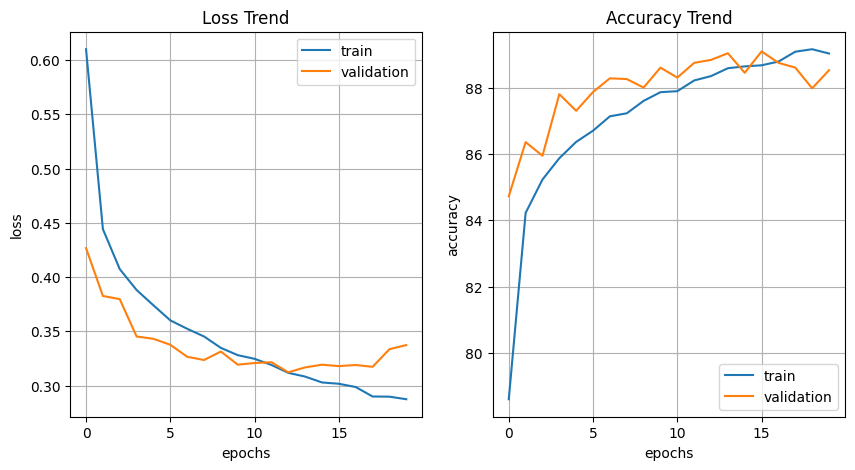

In [41]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Loss Trend')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()
plt.plot(train_loss_list, label='train')
plt.plot(val_loss_list, label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Accuracy Trend')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.plot(train_accuracy_list, label='train')
plt.plot(val_accuracy_list, label='validation')
plt.legend()

plt.show()